# Ανάλυση Συναισθημάτων (Sentiment Analysis)


In [1]:
#imports
import time
start_time = time.time()

import collections
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud

## Προεπεξεργασία και καθάρισμα δεδομένων
Αρχικά, καθαρίζουμε τα *train2017.tsv* και *test2017.tsv* και τα αποθηκεύουμε ως * *_cleaned.tsv*.
Πιο συγκεκριμένα:
* κάνουμε πεζά τα tweets
* αφαιρούμε σύμβουλα, όπως Hashtags, κτλπ
* αφαιρούμε τα emoji και τους άγνωστους-μη αγγλικούς χαρακτήρες
* διαγράφουμε εντελώς τα mentions(@) και τα url's
* αφαιρούμε τα stop-words
* εφαρμόζουμε το stemming στις εναπομείναντες λέξεις

In [2]:
def stemming(w):
    ps = PorterStemmer()
    return ps.stem(w)

def cleaning(s, stem_flag=1):
    s = re.sub(r"(?:\@|http)\S+", "", s)
    s = s.lower()
    s = s.replace("\\u002c", ',')   # \u002c : ,
    s = s.replace("\\u2019", '')    # \u2019 : '
    s = s.replace("&amp;", '&')     # &amp; : &
    for char in string.punctuation:
        s = s.replace(char, ' ')
    cleared_string = ""
    word_tokens = word_tokenize(s) 
    for word in word_tokens:
        if word not in stopwords.words('english') and all(ord(char) < 128 for char in word):
                if stem_flag:
                    cleared_string += stemming(word) #not for wordclouds
                else:
                    cleared_string += word
                cleared_string += ' '
    return cleared_string

print("Cleaning train2017.tsv...")
with open('../twitter_data/train2017.tsv') as input_file, open('../twitter_data/train2017_cleaned.tsv', 'w') as output_file:
    reader = csv.reader(input_file, delimiter='\t')
    for row in reader:
        cleaned_tweet = cleaning(row[3])
        output_file.write(row[0] + '\t' + row[1] + '\t' + row[2] + '\t' + cleaned_tweet + '\n')
print("Done. Saved as train2017_cleaned.tsv \n")

print("Cleaning test2017.tsv...")
with open('../twitter_data/test2017.tsv') as input_file, open('../twitter_data/test2017_cleaned.tsv', 'w') as output_file:
    reader = csv.reader(input_file, delimiter='\t')
    for row in reader:
        cleaned_tweet = cleaning(row[3])
        output_file.write(row[0] + '\t' + row[1] + '\t' + row[2] + '\t' + cleaned_tweet + '\n')
print("Done. Saved as test2017_cleaned.tsv")

Cleaning train2017.tsv...
Done. Saved as train2017_cleaned.tsv 

Cleaning test2017.tsv...
Done. Saved as test2017_cleaned.tsv


## Ανάλυση των δεδομένων
Παρουσιάζουμε κάποιες ενδιαφέρουσες και χρήσιμες πληροφορίες που συγκεντρώσαμε, αναλύοντας τα tweets από το *train2017_cleaned.tsv.

In [3]:
all_tweets = []
pos_tweets = []
neg_tweets = []
neu_tweets = []
labels = []
with open('../twitter_data/train2017.tsv') as input_file:
    reader = csv.reader(input_file, delimiter='\t')
    for row in reader:
        cleaned_tweet = cleaning(row[3], 0)
        all_tweets.append(cleaned_tweet)
        if row[2] == "positive":
            pos_tweets.append(cleaned_tweet)
        elif row[2] == "negative":
            neg_tweets.append(cleaned_tweet)
        else: #if neutral
            neu_tweets.append(cleaned_tweet)

### Wordclouds

Δημιουργούμε κάποια WordClouds με:
* τις συνηθέστερες λέξεις σε ολόκληρο το σύνολο δεδομένων
* τις συνηθέστερες λέξεις στο σύνολο δεδομένων για τα αρνητικά, τα θετικά και τα ουδέτερα tweets

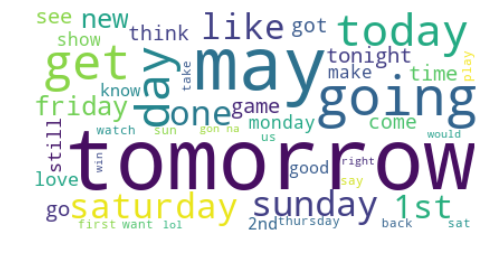

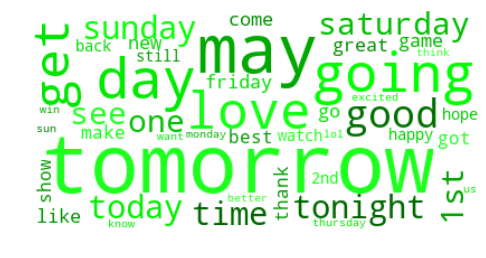

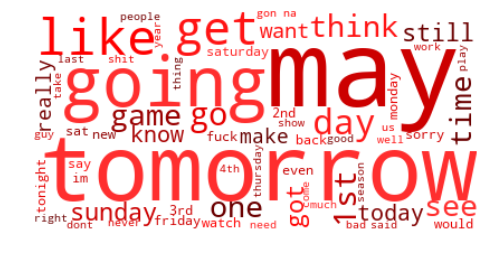

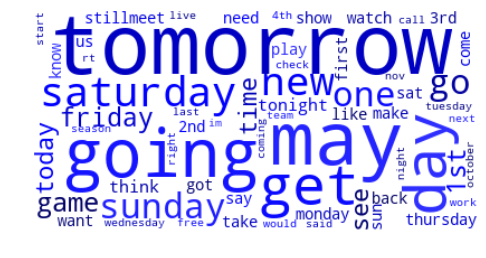

Done. Saved also in scr/wordclouds/.


In [4]:
def red_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    hue = 360.0
    h = int(hue)
    s = int(100.0)
    l = int(40.0 * float(random.uniform(0.5, 1.5)))
    return "hsl({}, {}%, {}%)".format(h, s, l)

def green_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    hue = 120.0
    h = int(hue)
    s = int(100.0)
    l = int(40.0 * float(random.uniform(0.5, 1.5)))
    return "hsl({}, {}%, {}%)".format(h, s, l)

def blue_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    hue = 240.0
    h = int(hue)
    s = int(100.0)
    l = int(40.0 * float(random.uniform(0.5, 1.5)))
    return "hsl({}, {}%, {}%)".format(h, s, l)

def generate_wc(x, name, main_color=None):
    if(main_color=="green"):
        curr_wc = WordCloud( background_color = 'white', stopwords = stopwords.words('english'), min_font_size = 10, color_func=green_color_func).generate(x)
    elif(main_color=="red"):
        curr_wc = WordCloud( background_color = 'white', stopwords = stopwords.words('english'), min_font_size = 10, color_func=red_color_func).generate(x)
    elif(main_color=="blue"):
        curr_wc = WordCloud( background_color = 'white', stopwords = stopwords.words('english'), min_font_size = 10, color_func=blue_color_func).generate(x)
    else:
        curr_wc = WordCloud( background_color = 'white', stopwords = stopwords.words('english'), min_font_size = 10).generate(x)
    plt.figure(figsize = [8, 8])
    plt.imshow(curr_wc, interpolation="bilinear")
    plt.axis("off")
    name = 'wordclouds/' + name + '.png'
    plt.savefig(name, format="png")
    plt.show()

generate_wc((" ").join(all_tweets), "all_tweets_wordcloud")
generate_wc((" ").join(pos_tweets), "pos_tweets_wordcloud", "green")
generate_wc((" ").join(neg_tweets), "neg_tweets_wordcloud", "red")
generate_wc((" ").join(neu_tweets), "neu_tweets_wordcloud", "blue")
print("Done. Saved also in scr/wordclouds/.")    

### Graphs

Δημιουργούμε κάποια γραφήματα με:
* τις θετικές/αρνητικές λέξεις με τις περισσότερες εμφανίσεις στα θετικά/αρνητικά tweets
* τα mentions στα tweets όπου εμφανίζονται πιο συχνά για θετικό/αρνητικό λόγο

Generating Graphs...
Done.


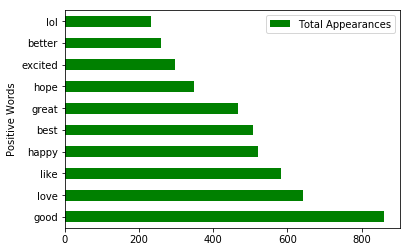

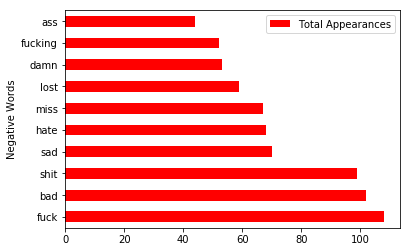

In [5]:
print("Generating Graphs...")

def generate_graph(curr_list, curr_type):
    wordcount = {}
    for tweet in curr_list:
        tweet_tokens = word_tokenize(tweet)
        for word in tweet_tokens:
            with open('../lexica/affin/affin.txt') as input_file:
                reader = csv.reader(input_file, delimiter='\t')
                for row in reader:
                    if(row[0][0]>word[0]):
                        break
                    if(row[0] == word):
                        if(curr_type == "positive"):
                            if(int(row[1])>=2):
                                if word not in wordcount:
                                    wordcount[word] = 1
                                else:
                                    wordcount[word] += 1
                        else: #elif(curr_type = "negative"):
                            if(int(row[1])<=-2):
                                if word not in wordcount:
                                    wordcount[word] = 1
                                else:
                                    wordcount[word] += 1
                        break
    return wordcount

word_counter = collections.Counter(generate_graph(pos_tweets, "positive"))
lst = word_counter.most_common(10)
df = pd.DataFrame(lst, columns = ['Positive Words', 'Total Appearances'])
fig = df.plot.barh(x='Positive Words',y='Total Appearances', color='green')

word_counter = collections.Counter(generate_graph(neg_tweets, "negative"))
lst = word_counter.most_common(10)
df = pd.DataFrame(lst, columns = ['Negative Words', 'Total Appearances'])
df.plot.barh(x='Negative Words',y='Total Appearances', color='red')

print("Done.") 

Generating Graphs...


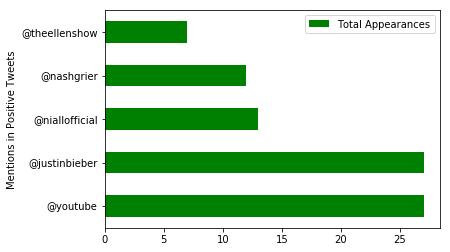

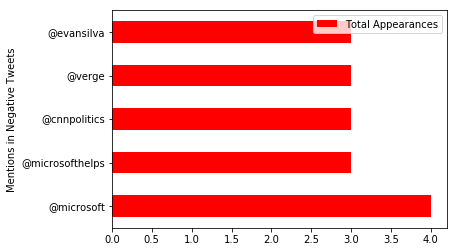

In [6]:
print("Generating Graphs...")

mentions_list = {}
with open('../twitter_data/train2017.tsv') as input_file:
    reader = csv.reader(input_file, delimiter='\t')
    for row in reader:
        row[3] = row[3].replace('@ ', '@-')
        flag = 0
        word_tokens = word_tokenize(row[3]) 
        for word in word_tokens:
            word = word.lower()
            if flag:
                if word.isalpha():
                    word = "@"+word
                    if(word not in mentions_list):
                        if(row[2]=="positive"):
                            mentions_list[word] = 1
                        elif(row[2]=="negative"):
                            mentions_list[word] = -1
                    else:
                        if(row[2]=="positive"):
                            mentions_list[word] += 1
                        elif(row[2]=="negative"):
                            mentions_list[word] -= 1
                flag = 0
            elif(word=="@"):
                flag = 1

best_mentions_dict = {}
worst_mentions_dict = {}
for key in mentions_list:
    if(mentions_list[key]>0):
        best_mentions_dict[key] = mentions_list[key]
    if(mentions_list[key]<0):
        worst_mentions_dict[key] = mentions_list[key]*(-1)
                
best_mentions = collections.Counter(best_mentions_dict).most_common()
worst_mentions = collections.Counter(worst_mentions_dict).most_common()

num_of_items = 5

df = pd.DataFrame(best_mentions[:num_of_items], columns = ['Mentions in Positive Tweets', 'Total Appearances'])
df.plot.barh(x='Mentions in Positive Tweets',y='Total Appearances', color='green')

df = pd.DataFrame(worst_mentions[:num_of_items], columns = ['Mentions in Negative Tweets', 'Total Appearances'])
df.plot.barh(x='Mentions in Negative Tweets',y='Total Appearances', color='red')

## Vectorization - εξαγωγή χαρακτηριστικών
Εξάγουμε και ετοιμάζουμε τα χαρακτηριστικά(features) για κάθε tweet χρησιμοποιώντας:
* Bag-of-words
* Tf_idf
* word embeddings

In [7]:
train_tweets = []
labels = []
with open('../twitter_data/train2017_cleaned.tsv') as input_file:
    reader = csv.reader(input_file, delimiter='\t')
    for row in reader:
        labels.append(row[2])
        train_tweets.append(row[3])

test_tweets = []
with open('../twitter_data/test2017_cleaned.tsv') as input_file:
    reader = csv.reader(input_file, delimiter='\t')
    for row in reader:
        test_tweets.append(row[3])

### Bag-of-words

In [8]:
#for train2017_cleaned.tsv
bow_vectorizer = CountVectorizer()
bow_xtrain = bow_vectorizer.fit_transform(train_tweets)    
#bow_xtrain = bow_vectorizer.fit_transform(train_tweets[:3])    
#print(bow_xtrain.shape)
#print(vectorizer.get_feature_names())
#print(bow_xtrain.toarray())
output = open('pickles/bow_xtrain.pkl', 'wb')
pickle.dump(bow_xtrain, output)
output.close()
print("pickles/bow_xtrain.pkl saved successfully.")

#for test2017_cleaned.tsv
bow_vectorizer = CountVectorizer()
bow_xtest = bow_vectorizer.fit_transform(test_tweets)    
#bow_xtest = bow_vectorizer.fit_transform(test_tweets[:3])    
#print(bow_xtest.shape)
#print(vectorizer.get_feature_names())
#print(bow_xtest.toarray())
output = open('pickles/bow_xtest.pkl', 'wb')
pickle.dump(bow_xtest, output)
output.close()
print("pickles/bow_xtest.pkl saved successfully.")

pickles/bow_xtrain.pkl saved successfully.
pickles/bow_xtest.pkl saved successfully.


### Tf_idf

In [9]:
#for train2017_cleaned.tsv
tfidf_vectorizer = TfidfVectorizer()
tfdif_xtrain = tfidf_vectorizer.fit_transform(train_tweets)
#print(tfdif_xtrain.shape)
output = open('pickles/tfdif_xtrain.pkl', 'wb')
pickle.dump(tfdif_xtrain, output)
output.close()
print("pickles/tfdif_xtrain.pkl saved successfully.")

#for test2017_cleaned.tsv
tfidf_vectorizer = TfidfVectorizer()
tfdif_xtest = tfidf_vectorizer.fit_transform(test_tweets)
#print(tfdif_xtest.shape)
output = open('pickles/tfdif_xtest.pkl', 'wb')
pickle.dump(tfdif_xtest, output)
output.close()
print("pickles/tfdif_xtest.pkl saved successfully.")

pickles/tfdif_xtrain.pkl saved successfully.
pickles/tfdif_xtest.pkl saved successfully.


## Εκτίμηση συναισθημάτων μέσω των Λεξικών

In [10]:
# "../lexica/emotweet/valence_tweet.txt" & "../lexica/nrc/val.txt" not used, because too large for the current machine (nick's)

compatible_lexica_names = ["../lexica/affin/affin.txt"]
combined_lexica = []
eng = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

for lexica in compatible_lexica_names:
    print(lexica)
    with open(lexica) as input_file:
        reader = csv.reader(input_file, delimiter='\t')
        for row in reader:
            if(row[0].isalpha()) and not any(c not in eng for c in row[0]):
                if(lexica == "../lexica/affin/affin.txt"):
                    value = float(row[1])/5
                elif(lexica == "../lexica/nrctag/val.txt"):
                    value = float(row[1])/9
                else:
                    value = float(row[1])
                combined_lexica.append(tuple((row[0], value)))

combined_lexica.sort(key=lambda tup:tup[0])
lexica_predictions = []

for tweet in test_tweets:
    value = 0
    words = 0
    word_tokens = word_tokenize(tweet) 
    for word in word_tokens:
        words += 1
        for lexica_word in combined_lexica:
            if(lexica_word[0][0]>word[0]):
                break
            if(lexica_word[0] == word):
                value += lexica_word[1]
                break

    if(words==0):
        lexica_predictions.append(" ")
    elif((value/words)>0.01):
        lexica_predictions.append("positive")
    elif((value/words)<-0.01):
        lexica_predictions.append("negative")
    else:
        lexica_predictions.append("neutral")
             
output = open('pickles/lexica_predictions.pkl', 'wb')
pickle.dump(lexica_predictions, output)
output.close()
print("pickles/lexica_predictions.pkl saved successfully.")

../lexica/affin/affin.txt
pickles/lexica_predictions.pkl saved successfully.


## Δοκιμάζουμε Ταξινομήτες

* SVM
* KNN

Δοκιμάζουμε τους παραπάνω ταξινομητές/learning-models για τα χαρακτηριστικά που συγκεντρώσαμε από τις μεθόδους BOW και TFID.

In [11]:
#we are inserting to a list the right answers for the tweets
answers = []
with open('../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt') as input_file:
    reader = csv.reader(input_file, delimiter='\t')
    for row in reader:
        answers.append(row[1])

#we are running the validation for total_features
#NOTE: later we are going to use train_test_split() function
total_features = 2000

results = [["Bag-of-words", "-", "-"], ["Tf_idf", "-", "-"]]

### SVM | Bag-of-words

In [12]:
bow_vectorizer = CountVectorizer(max_features = total_features)
bow_xtrain = bow_vectorizer.fit_transform(train_tweets[:total_features])
bow_xtest = bow_vectorizer.fit_transform(test_tweets[:total_features])

svc = svm.SVC(kernel='linear', C=1, probability=True)
svc = svc.fit(bow_xtrain, labels[:total_features])
y_pred = svc.predict(bow_xtest)

accuracy = f1_score(answers[:total_features], y_pred, average='macro')
results[0][1] = "{0:.0%}".format(accuracy)

### SVM | Tf_idf

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_features = total_features)
tfdif_xtrain = tfidf_vectorizer.fit_transform(train_tweets[:total_features])
tfdif_xtest = tfidf_vectorizer.fit_transform(test_tweets[:total_features])

svc = svm.SVC(kernel='linear', C=1, probability=True)
svc = svc.fit(tfdif_xtrain, labels[:total_features])
y_pred = svc.predict(tfdif_xtest)
      
accuracy = f1_score(answers[:total_features], y_pred, average='macro')
results[1][1] = "{0:.0%}".format(accuracy)

### KNN | Bag-of-words

In [14]:
tfidf_vectorizer = TfidfVectorizer(max_features = total_features)
tfdif_xtrain = tfidf_vectorizer.fit_transform(train_tweets[:total_features])
tfdif_xtest = tfidf_vectorizer.fit_transform(test_tweets[:total_features])

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(bow_xtrain, labels[:total_features])
y_pred = knn.predict(bow_xtest)
      
accuracy = f1_score(answers[:total_features], y_pred, average='macro')
results[0][2] = "{0:.0%}".format(accuracy)

### KNN | Tf_idf

In [15]:
tfidf_vectorizer = TfidfVectorizer(max_features = total_features)
tfdif_xtrain = tfidf_vectorizer.fit_transform(train_tweets[:total_features])
tfdif_xtest = tfidf_vectorizer.fit_transform(test_tweets[:total_features])

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(tfdif_xtrain, labels[:total_features])
y_pred = knn.predict(tfdif_xtest)
      
accuracy = f1_score(answers[:total_features], y_pred, average='macro')
results[1][2] = "{0:.0%}".format(accuracy)

## Παρουσίαση Αποτελεσμάτων

### Αποτελέσματα για διαφορετικούς ταξινομητές

In [16]:
df = pd.DataFrame(results, columns = ['Method', 'SVM', 'KNN'])

print("Results for", total_features, "total features:")

df

Results for 2000 total features:


,Method,SVM,KNN
0,Bag-of-words,33%,27%
1,Tf_idf,32%,33%


In [17]:
#with open('pickles/lexica_predictions.pkl', 'rb') as f:
#    lexica_predictions = pickle.load(f)

accuracy = f1_score(answers, lexica_predictions, average='macro')
print("Also, predicting the type of each tweet through some lexica, we achieved {0:.0%}".format(accuracy), "accuracy.")

Also, predicting the type of each tweet through some lexica, we achieved 39% accuracy.


/home/nickst/anaconda2/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Σχολιασμός αποτελεσμάτων

In [18]:
total_time = time.time() - start_time
print("Total Execution Time: %.2f" % (total_time/60))

Total Execution Time: 8.58



Στην παρούσα εργασία με αντικείμενο την Ανάλυση Συναισθημάτων πάνω σε ένα σύνολο από tweets, καταλήξαμε σε διάφορα αρκετά ενδιαφέροντα αποτελέσματα.

Αρχικά, μέσω των wordclouds που δημιουργήθηκαν για το αντίστοιχο μέρος της άσκησης παρατηρούμε πως, ανεξαρτήτως την συναισθηματική αξία του εκάστοτε tweet (θετικό, αρνητικό, ουδέτερο), κυρίαρχες λέξεις είναι οι *may* και *tomorrow*. Αυτή η παρατήρηση μας προδίδει πως ο μέσος άνθρωπος τείνει να δημοσιεύει συχνά πληροφορίες που αφορούν τις επόμενές του ημέρες, αλλά και σκέψεις που είναι αναμφίβολο για το αν ισχύουν και αν θα πραγματοποιηθούν. Επιπλέον, μια αξιοσημείωτη παρατήρηση για το αντίστοιχο wordcloud όλων των tweet είναι πως μπορεί εύκολα να διακριθεί και η λέξη *love*, το οποίο είναι κάτι αρκετά θετικό για την θέση που έχουν τα social media στην σημερινή κοινωνία και τι εκφράζεται μέσα σε αυτά.

Όσον αφορά τις πληροφορίες που παρουσιάστηκαν στα γραφήματα, στις 10 πιο συχνά εμφανιζόμενες λέξεις στα θετικά tweets είναι η λέξη *lol*, δείχνοντας μας πως υπάρχουν και αρκετά tweet χιουμοριστικού περιεχομένου στο διαδίκτυο. Επιπρόσθετα, στα γραφήματα με τους πιο μισητούς χρήστες, εμφανίζεται και ο λογαριασμός της *microsofthelps*, αποδεικνύοντας μας πως όταν κάποιος χρήστης έχει κάποιο πρόβλημα ή παράπονο, μπορεί να εκφράσει πολυ ακραιά την άποψη του.

Tέλος, όσον αφορά τους ταξινομητές, επιβεβαιώνεται η προυπάρχουσα πληροφορία πως ένας SVM είναι αρκετά πιο αποδοτικός από εναν KNN, ανεξαρτήτως του αριθμού των δεδομένων. Δεν καταφέραμε να υλοποιήσουμε την μέθοδο με τα word embeddings και την προσθήκη των επιπλέον χαρακτηριστικών, παρ 'ολα αυτά θεωρήσαμε ενδιαφέρον να δούμε τι ποσοστό ακριβείας υπάρχει εάν προβλέψουμε τα συναισθήματα από την αξία της κάθε λέξης μέσω του λεξικού ../lexica/affin/affin.txt .